In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Mestrado/2021.1/Redes Neurais Artificiais/RNA/')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import math

from models import utils, metrics, plots

from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import random
import seaborn as sns
from copy import deepcopy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
conjunto_1 = utils.make_coords(coord_limit_x = (2, 4), 
                               coord_limit_y = (8, 10),
                               target= 1,
                               len_set = 50) # Top left


conjunto_2 = utils.make_coords(coord_limit_x = (2,4), 
                               coord_limit_y = (2,4),
                               target= 0, 
                               len_set = 50) # Bottom

conjunto_3 = utils.make_coords(coord_limit_x = (8, 10), 
                               coord_limit_y = (8, 10),
                               target= 0,
                               len_set = 50) # Bottom right

conjunto_4 = utils.make_coords(coord_limit_x = (8, 10), 
                               coord_limit_y = (2, 4),
                               target= 1,
                               len_set = 50) # Bottom right

df_artificial_1 = pd.DataFrame(data= conjunto_2 + conjunto_4 + conjunto_1 + conjunto_3, columns=['x1', 'x2', 'target'])

for col in df_artificial_1.columns:
    if col != 'target':
        df_artificial_1 = utils.normalize_col(df_artificial_1, col)

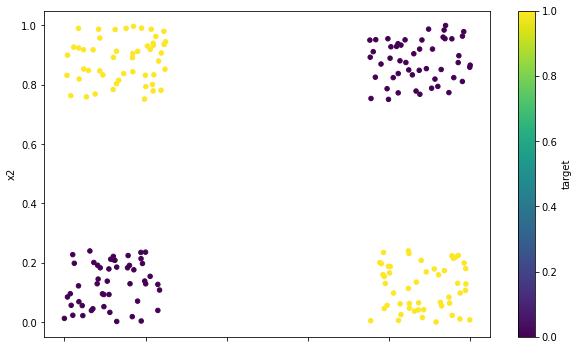

In [ ]:
df_artificial_1.plot.scatter( x='x1', y='x2', c='target', colormap='viridis', figsize=(10,6))

In [ ]:
def process(y):
    if y == 0:
        return [1, 0]
    if y == 1:
        return [0, 1]

def back(y):
    if y == [1, 0]:
        return 0
    if y == [0, 1]:
        return 1

In [ ]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_artificial_1, 'target', train_size=0.8, stratify=True)

df_train = X_train.copy()
df_train['target'] = [process(y) for y in y_train]#y_train

df_test = X_test.copy()
df_test['target'] = [process(y) for y in y_test]#y_test

In [ ]:
class RBF():

    def __init__(self, n_neuron_hide=5, sigma=2, qt_classes=3):

        self.q = n_neuron_hide
        self.sigma = sigma
        self.qt_classes = qt_classes

    def logistic(u):
        return 1.0 / (1.0 + np.exp(-u))

    def tanh(u):
        return (1 - np.exp(-u)) / (1 + np.exp(-u))
    
    def degrau(u, threshold=0):
        if u >= threshold: return 1
        else: return 0

    def get_optimal_weigths(df_train, col_target='target'):
        '''
        Função da OLAM
        '''
        X = np.asmatrix(df_train.drop([col_target], axis=1).values)
        D = np.asmatrix(np.array(df_train[col_target].tolist()))

        W = ((X.T * X).I * X.T * D)

        return W

    def predict_row(row, W, qt_classes=3):
        '''
        Função da OLAM
        '''
        result = (row.tolist() * W).tolist()[0]
        result_ = [RBF.logistic(y) for y in result]
        df = pd.DataFrame(zip([process(i) for i in range(qt_classes)], result_), columns=['class', 'prob'])
        output = df.sort_values(by='prob', ascending=False).iloc[0][0]
        return output


    def predict_dataframe(df, W, qt_classes=3):
        '''
        Função da OLAM
        '''
        list_result = []
        for idx, _ in df.iterrows():
            list_result.append(RBF.predict_row(df.iloc[idx], W, qt_classes=qt_classes))

        return list_result
    
    
    def fit(self, X_train, y_train):

        df_train = X_train.copy()
        df_train['target'] = y_train

        self.padroes_centro = np.random.uniform(size=(self.q, len(X_train.columns))) #row, col
        list_h = []
        for idx, row in X_train.iterrows():

            x = X_train.iloc[idx].tolist()
            
            h = []
            for padrao in self.padroes_centro:
                sub = np.subtract(np.array(x), np.array(padrao))
                calc = np.exp(-(np.dot(np.array(sub).T, np.array(sub)) / 2 * (self.sigma ** 2)))
                h.append(calc)

            list_h.append(h)

        M = np.asmatrix(list_h)
        input_olam = np.insert(M, 0, -1, axis=1)
        df_input_olam = pd.DataFrame(input_olam, columns = [f'h{i}' for i in range(input_olam.shape[1])])
        df_input_olam = pd.DataFrame(input_olam, columns = [f'h{i}' for i in range(input_olam.shape[1])])
        df_input_olam['target'] = df_train['target']

        self.weigths = RBF.get_optimal_weigths(df_input_olam, col_target='target')

    
    def predict(self, X_test):

        list_h_test = []
        for idx, row in X_test.iterrows():

            x = X_test.iloc[idx].tolist()
            
            h = []
            for padrao in self.padroes_centro:
                
                sub = np.subtract(np.array(x), np.array(padrao))
                calc = np.exp(-(np.dot(np.array(sub).T, np.array(sub)) / 2 * (self.sigma ** 2)))
                h.append(calc)

            list_h_test.append(h)

        M_teste = np.asmatrix(list_h_test)
        input_olam_test = np.insert(M_teste, 0, -1, axis=1)
        df_input_olam_test = pd.DataFrame(input_olam_test, columns = [f'h{i}' for i in range(input_olam_test.shape[1])])
        
        return RBF.predict_dataframe(df_input_olam_test, self.weigths, self.qt_classes)


In [ ]:
model_rbf = RBF(n_neuron_hide=5, sigma=0.1, qt_classes=2)

In [ ]:
model_rbf.fit(df_train.drop(['target'], axis=1).copy(), df_train['target'])

In [ ]:
df_test['predict'] = model_rbf.predict(X_test.copy())

In [ ]:
y_true = df_test['target'].apply(lambda x: back(x))
y_pred = df_test['predict'].apply(lambda x: back(x))

In [ ]:
metrics.taxa_acerto(y_true, y_pred)

1.0